### **BITCOIN TRADING STRATEGY**

**Project goal**: To train classification algorithms on a bitcoin trading strategy problem and improve the performance of one machine learning model by tuning its parameters using grid search and Bayesian optimization technique. 

- The idea is to predict when to buy or sell bitcoin. We define buy or sell signal and represent them as 1 or 0. We arrive at the signal by comparing the price trend of short-term and long-term behavior, that is, short-term moving average greater than a long-term moving average. Then we buy bitcoin; otherwise, we sell bitcoin. This is, therefore, a classification problem where we are interested in getting the direction of Bitcoin movement right. 

**Loading Helper Packages and Data**

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

In [43]:
from time import time

import joblib

# display all columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


from bayes_opt import BayesianOptimization

# Libraries for Deep Learning Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression

# needed for `HistGradientBoostingClassifier`
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

# from `keras.optimizers` import SGD

In [44]:
# To fetch financial data
import yfinance as yf

# Set the ticker as 'BTC-USD'
BTC_Ticker = yf.Ticker("BTC-USD")
BTC_Data = BTC_Ticker.history(period="5y")

In [45]:
# BTC_Ticker = yf.Ticker("BTC-USD")
# BTC_Data = BTC_Ticker.history(period="max")
BTC_Data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-16 00:00:00+00:00,8812.481445,8846.460938,8612.095703,8723.786133,31313981931,0.0,0.0
2020-01-17 00:00:00+00:00,8725.209961,8958.122070,8677.316406,8929.038086,36372139320,0.0,0.0
2020-01-18 00:00:00+00:00,8927.211914,9012.198242,8827.332031,8942.808594,32337772627,0.0,0.0
2020-01-19 00:00:00+00:00,8941.445312,9164.362305,8620.080078,8706.245117,34217320471,0.0,0.0
2020-01-20 00:00:00+00:00,8704.631836,8745.590820,8560.473633,8657.642578,26422375678,0.0,0.0


**Exploratory Data Analysis**

In [46]:
BTC_Data.shape

(1827, 7)

In [47]:
BTC_Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2020-01-16 00:00:00+00:00 to 2025-01-16 00:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1827 non-null   float64
 1   High          1827 non-null   float64
 2   Low           1827 non-null   float64
 3   Close         1827 non-null   float64
 4   Volume        1827 non-null   int64  
 5   Dividends     1827 non-null   float64
 6   Stock Splits  1827 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 114.2 KB


In [48]:
BTC_Data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1827.000000,1827.000000,1827.000000,1827.000000,1.827000e+03,1827.0,1827.0
mean,36999.580732,37808.597565,36158.483849,37044.398007,3.332867e+10,0.0,0.0
std,21617.219694,22084.789773,21135.463097,21647.798758,1.959412e+10,0.0,0.0
min,5002.578125,5331.833984,4106.980957,4970.788086,5.331173e+09,0.0,0.0
25%,20014.912109,20367.375977,19622.947266,20045.750977,2.061540e+10,0.0,0.0
50%,33416.976562,34399.390625,32052.316406,33472.632812,3.011673e+10,0.0,0.0
75%,51754.406250,52536.552734,50572.794922,51770.708984,4.044708e+10,0.0,0.0
max,106147.296875,108268.445312,105291.734375,106140.601562,3.509679e+11,0.0,0.0


In [49]:
# Check for any null values and remove them
print("Null Values =", BTC_Data.isnull().values.any())

Null Values = False


**Data Preparation**

- We create a target variable, the buy or sell signal. The target variable constitutes our trading strategy. When the shorter term moving average goes above the longer term moving average, then it is an indicator to buy and the vice versa is also true. 

In [50]:
# Create short simple moving average over the short window
BTC_Data["short_moving_avg"] = (
    BTC_Data["Close"].rolling(window=10, min_periods=1, center=False).mean()
)

# Create long simple moving average over the long window
BTC_Data["long_maving_avg"] = (
    BTC_Data["Close"].rolling(window=60, min_periods=1, center=False).mean()
)

# Create signals
BTC_Data["signal"] = np.where(
    BTC_Data["short_moving_avg"] > BTC_Data["long_maving_avg"], 1.0, 0.0
)

In [51]:
BTC_Data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,short_moving_avg,long_maving_avg,signal
Date,,,,,,,,,,
2020-01-16 00:00:00+00:00,8812.481445,8846.460938,8612.095703,8723.786133,31313981931,0.0,0.0,8723.786133,8723.786133,0.0
2020-01-17 00:00:00+00:00,8725.209961,8958.122070,8677.316406,8929.038086,36372139320,0.0,0.0,8826.412109,8826.412109,0.0
2020-01-18 00:00:00+00:00,8927.211914,9012.198242,8827.332031,8942.808594,32337772627,0.0,0.0,8865.210938,8865.210938,0.0
2020-01-19 00:00:00+00:00,8941.445312,9164.362305,8620.080078,8706.245117,34217320471,0.0,0.0,8825.469482,8825.469482,0.0
2020-01-20 00:00:00+00:00,8704.631836,8745.590820,8560.473633,8657.642578,26422375678,0.0,0.0,8791.904102,8791.904102,0.0


**Feature Engineering**

We create additional features in our dataset that will help us improve our model performance:

- Exponentail Moving Average: Gives us the price trend of the data.
- Relative Strength Indicator (RSI): Measures the change in price in recent time frame.
- Rate of change: Measures the percentage change between the stock's current price and past prices. 
- Stochastic Oscillator: Compares the current closing price of the stock with its previous closing price.

In [52]:
# calculation of exponential moving average


def EMA(df, n):
    EMA = pd.Series(df["Close"].ewm(span=n, min_periods=n).mean(), name="EMA_" + str(n))
    return EMA


BTC_Data["EMA10"] = EMA(BTC_Data, 10)
BTC_Data["EMA30"] = EMA(BTC_Data, 30)
BTC_Data["EMA200"] = EMA(BTC_Data, 200)
BTC_Data.head()


# calculation of rate of change
def RC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    RC = pd.Series(((M / N) * 100), name="RC_" + str(n))
    return RC


BTC_Data["RC10"] = RC(BTC_Data["Close"], 10)
BTC_Data["RC30"] = RC(BTC_Data["Close"], 30)


# Calculation of price momentum
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name="Momentum_" + str(n))
    return MOM


BTC_Data["MOM10"] = MOM(BTC_Data["Close"], 10)
BTC_Data["MOM30"] = MOM(BTC_Data["Close"], 30)


# calculation of relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period - 1]] = np.mean(u[:period])  # first value is sum of avg gains
    u = u.drop(u.index[: (period - 1)])
    d[d.index[period - 1]] = np.mean(d[:period])  # first value is sum of avg losses
    d = d.drop(d.index[: (period - 1)])
    rs = (
        u.ewm(com=period - 1, adjust=False).mean()
        / d.ewm(com=period - 1, adjust=False).mean()
    )
    return 100 - 100 / (1 + rs)


BTC_Data["RSI10"] = RSI(BTC_Data["Close"], 10)
BTC_Data["RSI30"] = RSI(BTC_Data["Close"], 30)
BTC_Data["RSI200"] = RSI(BTC_Data["Close"], 200)

# calculation of stochastic oscillator.


def STOK(close, low, high, n):
    STOK = (
        (close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())
    ) * 100
    return STOK


def STOD(close, low, high, n):
    STOK = (
        (close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())
    ) * 100
    STOD = STOK.rolling(3).mean()
    return STOD


BTC_Data["%K10"] = STOK(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 10)
BTC_Data["%D10"] = STOD(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 10)
BTC_Data["%K30"] = STOK(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 30)
BTC_Data["%D30"] = STOD(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 30)
BTC_Data["%K200"] = STOK(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 200)
BTC_Data["%D200"] = STOD(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 200)

In [53]:
BTC_Data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,short_moving_avg,long_maving_avg,signal,EMA10,EMA30,EMA200,RC10,RC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-01-11 00:00:00+00:00,94700.835938,94977.687500,93840.046875,94566.593750,18860894100,0.0,0.0,96734.189062,96623.676562,1.0,95710.120067,96183.267835,78280.335026,-2.394835,-6.793529,146.835938,-5476.406250,44.946838,51.379882,55.370532,29.114642,23.465041,19.625928,15.817581,76.834322,75.736668
2025-01-12 00:00:00+00:00,94565.726562,95367.539062,93712.507812,94488.437500,20885130965,0.0,0.0,96494.345312,96688.747786,0.0,95487.995964,96073.923943,78441.609680,-3.688805,-6.791289,-2398.437500,-6970.820312,44.733806,51.301379,55.353729,28.434528,29.279118,19.167469,19.736800,76.702183,76.866278
2025-01-13 00:00:00+00:00,94488.890625,95837.000000,89260.101562,94516.523438,72978998252,0.0,0.0,96135.254687,96809.849349,0.0,95311.364595,95973.446491,78601.559072,-3.786488,-9.378997,-3590.906250,-6856.445312,44.838198,51.329023,55.358622,39.074281,32.207817,27.653235,22.148877,76.749668,76.762058
2025-01-14 00:00:00+00:00,94519.007812,97352.664062,94322.156250,96534.046875,53769675818,0.0,0.0,95965.036719,96900.983333,0.0,95533.670464,96009.614258,78779.991789,-1.811437,-8.955670,-1702.179688,-7764.648438,52.064998,53.299069,55.709040,54.071798,40.526869,38.267118,28.362607,80.160689,77.870847
2025-01-16 00:00:00+00:00,100500.351562,100540.546875,99363.328125,99414.851562,57226842112,0.0,0.0,96075.025781,97048.589583,0.0,96239.339755,96229.306987,78985.313779,-2.609017,-6.336642,1099.890625,-6614.867188,60.313940,55.933766,56.202408,75.486627,56.210902,53.422592,39.780982,85.031256,80.647204


Next, we claculate moving averages:

In [54]:
def MA(df, n):
    MA = pd.Series(df["Close"].rolling(n, min_periods=n).mean(), name="MA_" + str(n))
    return MA


BTC_Data["MA21"] = MA(BTC_Data, 10)
BTC_Data["MA63"] = MA(BTC_Data, 30)
BTC_Data["MA252"] = MA(BTC_Data, 200)
BTC_Data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,short_moving_avg,long_maving_avg,signal,EMA10,EMA30,EMA200,RC10,RC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-01-11 00:00:00+00:00,94700.835938,94977.687500,93840.046875,94566.593750,18860894100,0.0,0.0,96734.189062,96623.676562,1.0,95710.120067,96183.267835,78280.335026,-2.394835,-6.793529,146.835938,-5476.406250,44.946838,51.379882,55.370532,29.114642,23.465041,19.625928,15.817581,76.834322,75.736668,96734.189062,97535.648438,73292.773906
2025-01-12 00:00:00+00:00,94565.726562,95367.539062,93712.507812,94488.437500,20885130965,0.0,0.0,96494.345312,96688.747786,0.0,95487.995964,96073.923943,78441.609680,-3.688805,-6.791289,-2398.437500,-6970.820312,44.733806,51.301379,55.353729,28.434528,29.279118,19.167469,19.736800,76.702183,76.866278,96494.345312,97303.287760,73461.159707
2025-01-13 00:00:00+00:00,94488.890625,95837.000000,89260.101562,94516.523438,72978998252,0.0,0.0,96135.254687,96809.849349,0.0,95311.364595,95973.446491,78601.559072,-3.786488,-9.378997,-3590.906250,-6856.445312,44.838198,51.329023,55.358622,39.074281,32.207817,27.653235,22.148877,76.749668,76.762058,96135.254687,97074.739583,73625.718320
2025-01-14 00:00:00+00:00,94519.007812,97352.664062,94322.156250,96534.046875,53769675818,0.0,0.0,95965.036719,96900.983333,0.0,95533.670464,96009.614258,78779.991789,-1.811437,-8.955670,-1702.179688,-7764.648438,52.064998,53.299069,55.709040,54.071798,40.526869,38.267118,28.362607,80.160689,77.870847,95965.036719,96815.917969,73806.787871
2025-01-16 00:00:00+00:00,100500.351562,100540.546875,99363.328125,99414.851562,57226842112,0.0,0.0,96075.025781,97048.589583,0.0,96239.339755,96229.306987,78985.313779,-2.609017,-6.336642,1099.890625,-6614.867188,60.313940,55.933766,56.202408,75.486627,56.210902,53.422592,39.780982,85.031256,80.647204,96075.025781,96595.422396,73999.425234


- We now move features that are irrelevant to our prediction such as High, Low, and Open values. We drop the short and long moving average features since we have already defined our trading signals.

In [55]:
# excluding columns that are not needed for our prediction.

BTC_Data = BTC_Data.drop(
    [
        "High",
        "Low",
        "Open",
        "short_moving_avg",
        "long_maving_avg",
        "Dividends",
        "Stock Splits",
    ],
    axis=1,
)

In [56]:
BTC_Data = BTC_Data.dropna(axis=0)

- Visualizing the Bitcoin price trend over the four years:

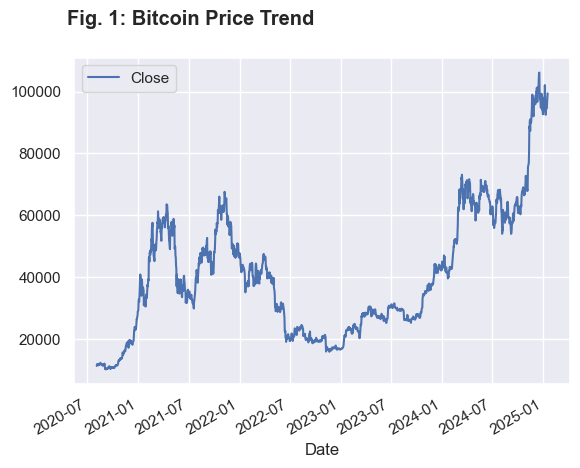

In [57]:
BTC_Data[["Close"]].plot(grid=True)
plt.suptitle(
    "Fig. 1: Bitcoin Price Trend", fontweight="bold", horizontalalignment="right"
)
plt.show()

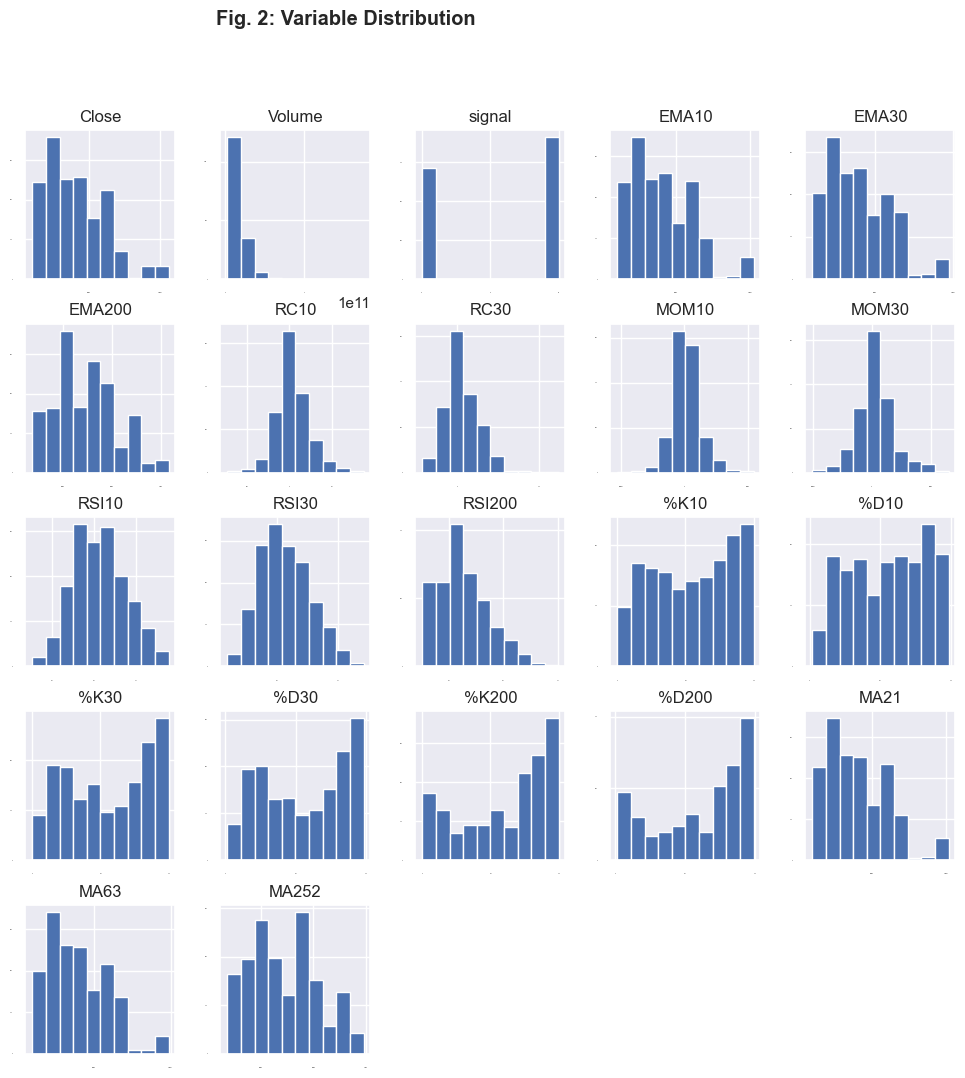

In [58]:
# Histograms
BTC_Data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12, 12))
plt.suptitle(
    "Fig. 2: Variable Distribution", fontweight="bold", horizontalalignment="right"
)
plt.show()

- Visualize the proportion of sell to buy signals in our dataset.

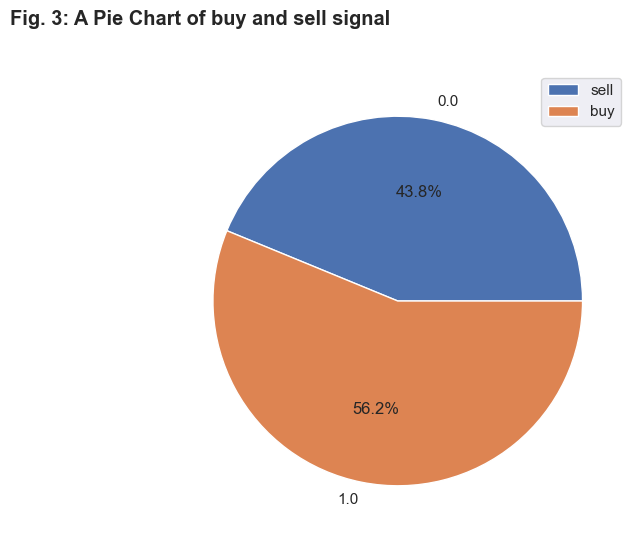

In [59]:
fig = plt.figure()
plot = (
    BTC_Data.groupby("signal")
    .size()
    .plot(kind="pie", figsize=(6, 6), autopct="%1.1f%%", y="signal")
)
plt.suptitle(
    "Fig. 3: A Pie Chart of buy and sell signal",
    fontweight="bold",
    horizontalalignment="right",
)
plt.legend(["sell", "buy"])
plt.show()

In [60]:
BTC_Data.groupby(["signal"]).size()

signal
0.0    712
1.0    914
dtype: int64

- Relationship between our variables using a correlation matrix of the returns.

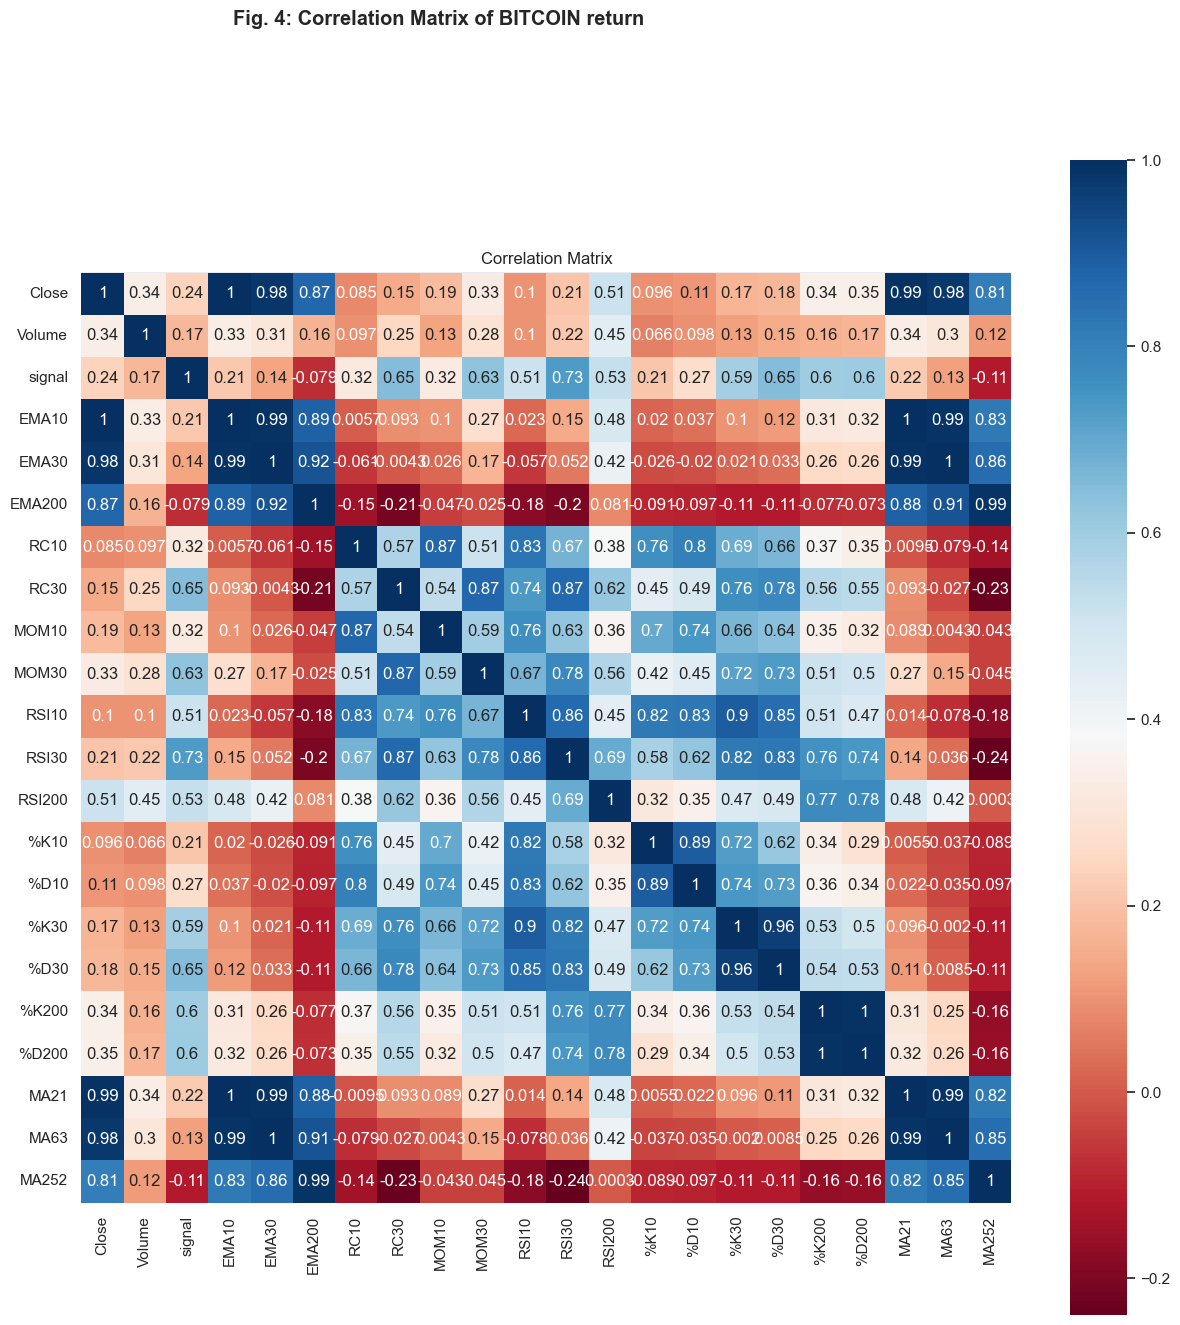

In [61]:
# correlation
BTC_Data_returns = BTC_Data.shift()
correlation = BTC_Data_returns.corr()
plt.figure(figsize=(15, 15))
plt.title("Correlation Matrix")
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap="RdBu")
plt.suptitle(
    "Fig. 4: Correlation Matrix of BITCOIN return",
    fontweight="bold",
    horizontalalignment="right", 
)
plt.show()

**Modeling**

In [62]:
# Train Test split with 80:20 ratio
def get_holdout_set(target, features, period=6):
    idx =pd.IndexSlice
    label = target.name
    dates = np.sort(y.index.get_level_values("Date").unique())
    cv_start, cv_end = dates[0], dates[-period - 2]
    holdout_start, holdout_end = dates[-period - 1], dates[-1]

    df = features.join(target.to_frame())
    train = df.loc[idx[:, cv_start:cv_end], :]
    y_train, X_train = train[label], train.drop(label, axis=1)

    test = df.loc[idx[:, holdout_start:holdout_endl, :]]
    y_test, X_test = test[label], test.drop(label, axis=1)
    return y_train, X_train, y_test, X_test

In [63]:
subset_validation = BTC_Data[1301:]

In [64]:
subset_validation.shape

(325, 22)

In [65]:
# split out validation dataset for the end
subset_dataset = BTC_Data[:1300]
y = subset_dataset["signal"]
X = subset_dataset.loc[:, BTC_Data.columns != "signal"]
X.index = pd.to_datetime(X.index)
validation_size = 0.2
seed = 1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=validation_size, random_state=1
)

In [66]:
subset_dataset.shape

(1300, 22)

- We create a validation dataset that consists of the remaining data we did not pick in the subset. This validation dataset will only  be used in basktesting our model.

In [67]:
subset_validation = BTC_Data[1300:]
y_validation = subset_validation["signal"]
X_validation = subset_validation.loc[:, BTC_Data.columns != "signal"]

In [68]:
X_validation.shape

(326, 21)

**Baseline Classifier**

- It's important to train a baseline classifier that will be used to compare with the real classifiers. We use the sklearn ```DummyClassifier``` as our baseline classifier and choose ```strategy=stratified``` that predicts the most frequent class.

In [69]:
# test options for classification
num_folds = 10
seed = 42
scoring = "accuracy"
metrics = {
    "balanced_accuracy": "Accuracy",
    "roc_auc": "AUC",
    "neg_log_loss": "Log Loss",
    "f1_weighted": "F1",
    "precision_weighted": "Precision",
    "recall_weighted": "Recall",
}

Cross-valiation function that will help us evaluate different algorithms:

In [70]:
def run_cv(clf, X=X, y=y, metrics=metrics, cv=10, n_jobs=-1):
    start = time()
    scores = cross_validate(
        estimator=clf,
        X=X,
        y=y,
        scoring=list(metrics.keys()),
        cv=cv,
        return_train_score=True,
        n_jobs=n_jobs,
        verbose=1,
    )
    duration = time() - start
    return scores, duration

We also define a function that will help us manipulate the cross-validation output and plot them.

In [71]:
def stack_results(scores):
    columns = pd.MultiIndex.from_tuples(
        [tuple(m.split("_", 1)) for m in scores.keys()], names=["Dataset", "Metric"]
    )
    data = np.array(list(scores.values())).T
    df = pd.DataFrame(data=data, columns=columns).iloc[:, 2:]
    results = pd.melt(df, value_name="Value")
    results.Metric = results.Metric.apply(lambda x: metrics.get(x))
    results.Dataset = results.Dataset.str.capitalize()
    return results

We finally define a function that will display the metrics of our models as box plots as to allow us to visualize the distribution of the model performance. 

In [72]:
def plot_result(df, model=None, fname=None):
    m = list(metrics.values())
    g = sns.catplot(
        x="Dataset",
        y="Value",
        hue="Dataset",
        col="Metric",
        data=df,
        col_order=m,
        order=["Train", "Test"],
        kind="box",
        col_wrap=3,
        sharey=False,
        height=4,
        aspect=1.2,
    )
    df = df.groupby(["Metric", "Dataset"]).Value.mean().unstack().loc[m]
    for i, ax in enumerate(g.axes.flat):
        s = f"Train: {df.loc[m[i], 'Train']:>7.4f}\nTest:  {df.loc[m[i], 'Test'] :>7.4f}"
        ax.text(
            0.05,
            0.85,
            s,
            fontsize=10,
            transform=ax.transAxes,
            bbox=dict(facecolor="white", edgecolor="grey", boxstyle="round,pad=0.5"),
        )
    g.fig.suptitle(model, fontsize=16)
    g.fig.subplots_adjust(top=0.9)
    if fname:
        g.savefig(fname, dpi=300);

Dummy classifiers:

In [73]:
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
algo = "dummy_clf"

We run dummy classifier using cross-validation with the defined metrics used to measure model performance.

In [74]:
fname = f"{algo}.joblib"

dummy_cv_result, run_time_algo = run_cv(dummy_clf)
joblib.dump(dummy_cv_result, fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


['dummy_clf.joblib']

A table with the model performance on each metric:

In [76]:
dummy_result = stack_results(dummy_cv_result)
dummy_result.groupby(["Metric", "Dataset"]).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.494582,0.507744
Accuracy,0.494582,0.507744
F1,0.498031,0.510437
Log Loss,-18.049553,-17.649068
Precision,0.497393,0.510539
Recall,0.499231,0.510342


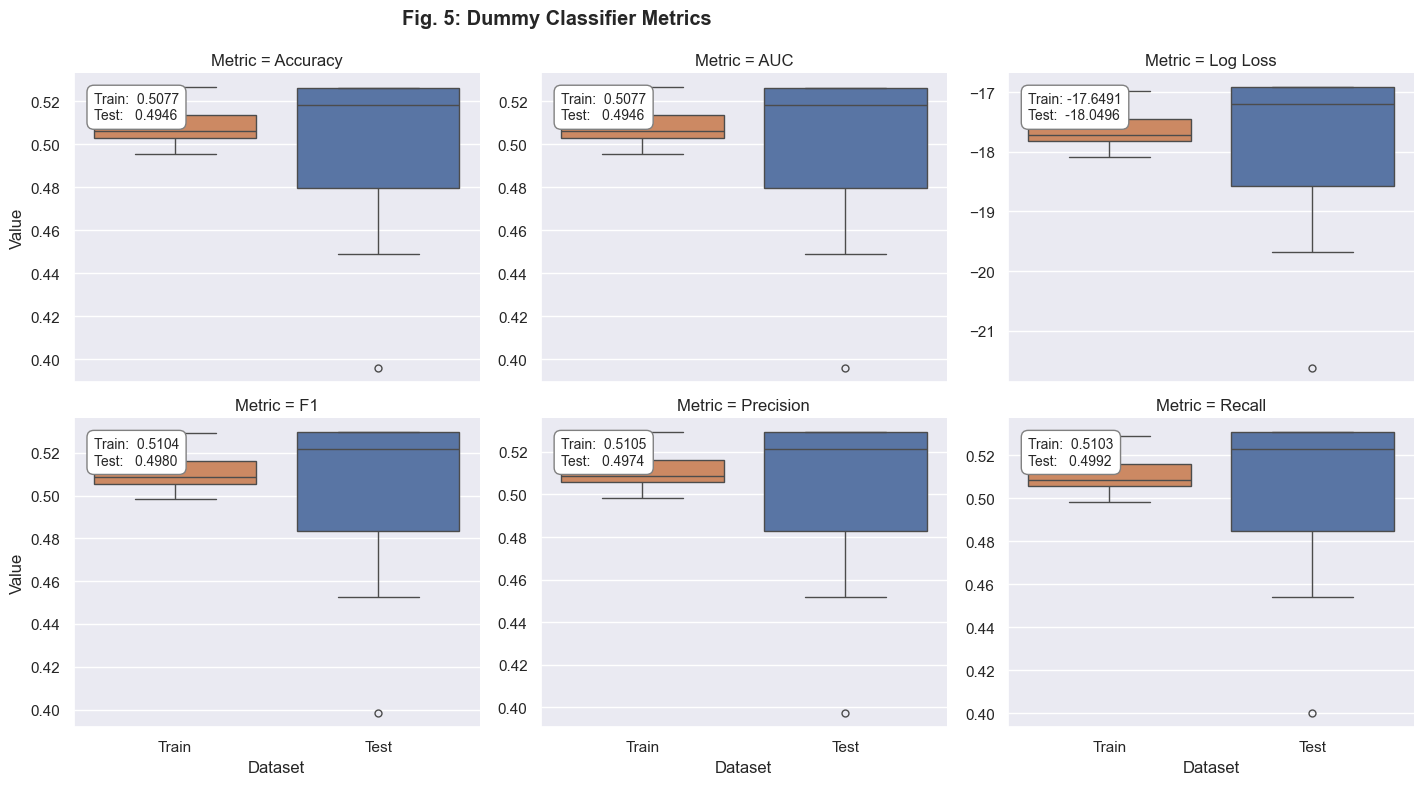

In [77]:
plot_result(dummy_result, model="Dummy Classifier")
plt.suptitle(
    "Fig. 5: Dummy Classifier Metrics", fontweight="bold", horizontalalignment="right"
)
plt.show()

**Defining Classification Algorithms**

In [78]:
# spot check the algorithms
models = []
models.append(("LR", LogisticRegression(n_jobs=-1)))
models.append(("LDA", LinearDiscriminantAnalysis()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("CART", DecisionTreeClassifier()))
models.append(("NB", GaussianNB()))
# Neural Network
models.append(("NN", MLPClassifier()))
#Ensemble models
#Boosting Methods
models.append(("AB", AdaBoostClassifier()))
models.append(("GBM", GradientBoostingClassifier()))
# Bagging methods
models.append(("RF", RandomForestClassifier(n_jobs=-1)))

- We evaluate these models' performance using KFold cross-validation and record their mean and variance.

In [79]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(cv_results)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())

- Looking at the outputs, Random Forest Classifier outperforms the other models, and we select it at our preferred model. 

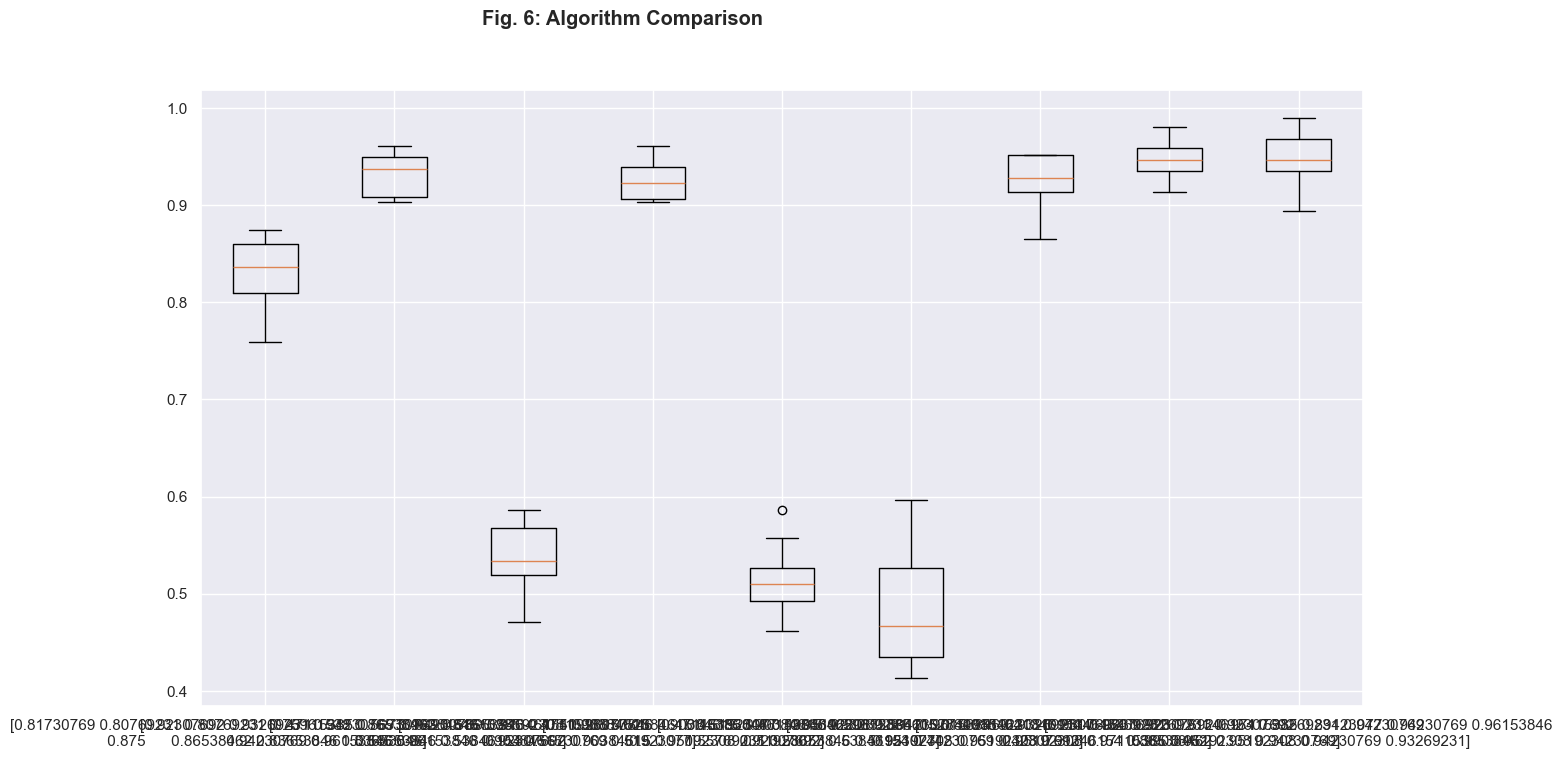

In [80]:
# compare algorithms
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15, 8)
plt.suptitle(
    "Fig. 6: Algorithm Comparison", fontweight="bold", horizontalalignment="right"
)
plt.show()

**Hyperparameter Tuning**

Since random forest was our best performer, we seek to tune its hyperparameters to improve the perfrormance even better.

**Grid Search**

In [81]:
# Grid Search: Random Forest Classifier

scaler = StandardScaler().fit(X_train)
rescaledx = scaler.transform(X_train)
n_estimators = [20, 80]
max_depth=[5, 10]
criterion= ["gini", "entropy"]
param_grid= dict(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion)
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_results = grid.fit(rescaledx, y_train)

# print Results
print("Best: %f using %s" % (grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_["mean_test_score"]
stds = grid_results.cv_results_["std_test_score"]
params = grid_results.cv_results_["params"]
ranks = grid_results.cv_results_["rank_test_score"]
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.951923 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}
#8 0.930769 (0.034077) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#5 0.937500 (0.032251) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#2 0.946154 (0.020261) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#4 0.946154 (0.028910) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#7 0.931731 (0.027349) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#6 0.934615 (0.030346) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#2 0.946154 (0.021154) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#1 0.951923 (0.023157) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


We now fix the bext hyperparameters to our model and use it to compare with the dummy classifier, using the same steps as in the dummy classifier problem.

In [82]:
# prepare model
model = RandomForestClassifier(
    criterion='gini', max_depth=10, n_estimators=20, n_jobs=-1
)

In [83]:
algo_forest = "random_forest"

In [84]:
fname = f"{algo_forest}.joblib"

random_forest_cv_result, run_time_algo_forest = run_cv(model)
joblib.dump(random_forest_cv_result, fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s finished


['random_forest.joblib']

Display the model performance table:

In [85]:
rf_result = stack_results(random_forest_cv_result)
rf_result.groupby(["Metric", "Dataset"]).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.918698,0.999992
Accuracy,0.822272,0.997882
F1,0.814005,0.997778
Log Loss,-0.817882,-0.041748
Precision,0.860067,0.997791
Recall,0.823846,0.997778


The above metrics in a box plot:

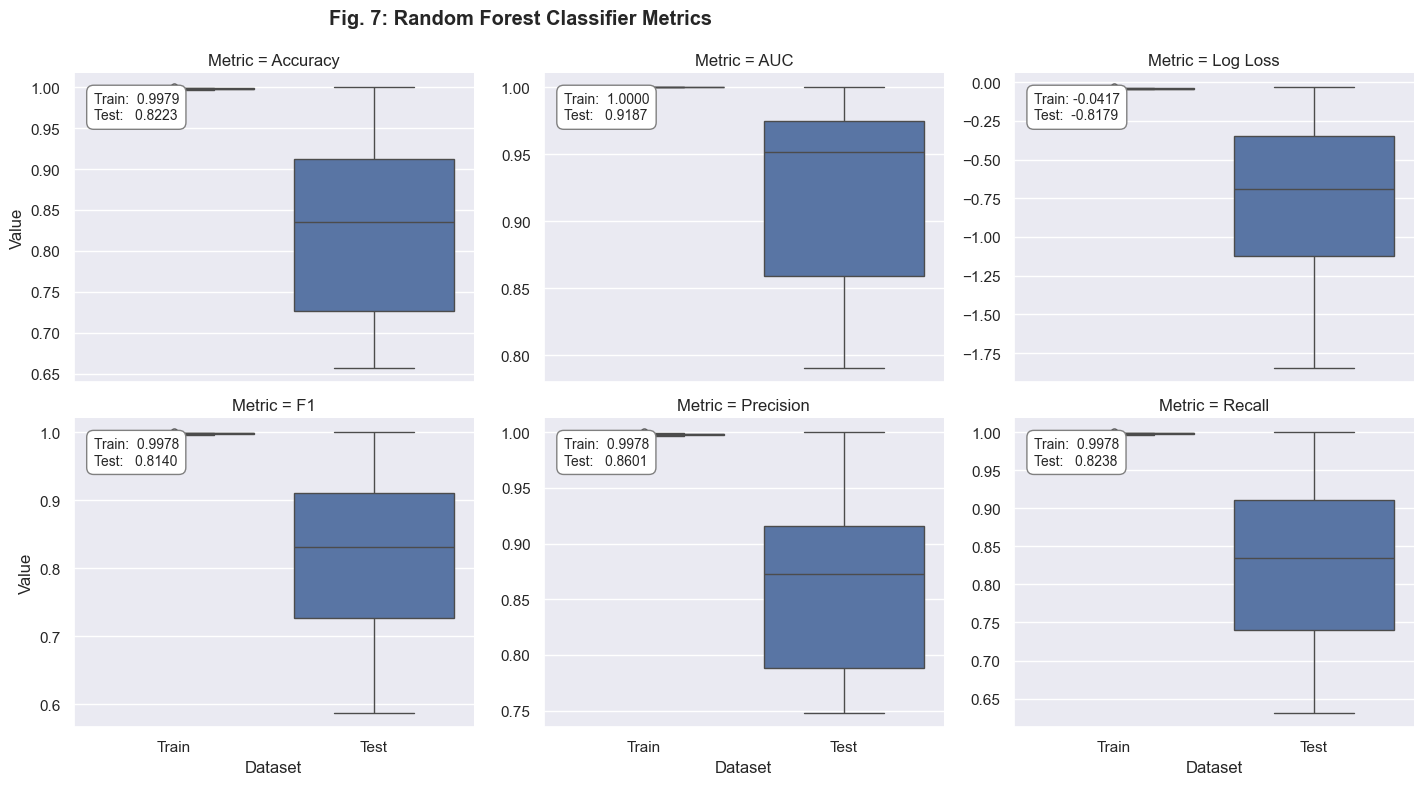

In [86]:
plot_result(rf_result, model="Random Forest Classifier")
plt.suptitle(
    "Fig. 7: Random Forest Classifier Metrics",
    fontweight="bold",
    horizontalalignment="right",
)
plt.show()

Comparing dummy model and rf classifier:

In [87]:
results = {
    "Baseline": dummy_result,
    "Random Forest": rf_result,
}
df = pd.DataFrame()
for model, result in results.items():
    df = pd.concat(
        [
            df,
            result.groupby(["Metric", "Dataset"])
            .Value.mean()
            .unstack()["Test"]
            .to_frame(model),
        ],
        axis=1,
    )

df.T.sort_values("AUC", ascending=False)

Metric,AUC,Accuracy,F1,Log Loss,Precision,Recall
Random Forest,0.918698,0.822272,0.814005,-0.817882,0.860067,0.823846
Baseline,0.494582,0.494582,0.498031,-18.049553,0.497393,0.499231


Random forest performance:

In [88]:
model = RandomForestClassifier(
    criterion="gini", n_estimators=80, max_depth=10, n_jobs=-1
)
model.fit(X_train, y_train)
# estimate accuracy on validation set
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.9461538461538461
[[116   7]
 [  7 130]]
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       123
         1.0       0.95      0.95      0.95       137

    accuracy                           0.95       260
   macro avg       0.95      0.95      0.95       260
weighted avg       0.95      0.95      0.95       260



Confusion matrix:

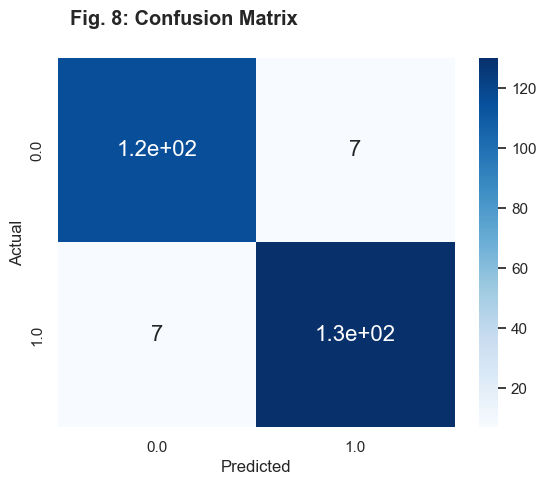

In [89]:
df_cm = pd.DataFrame(
    confusion_matrix(y_test, predictions),
    columns=np.unique(y_test),
    index=np.unique(y_test),
)
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})  # font sizes
plt.suptitle("Fig. 8: Confusion Matrix", fontweight="bold", horizontalalignment="right")
plt.show()

Variables with more predictive powers:

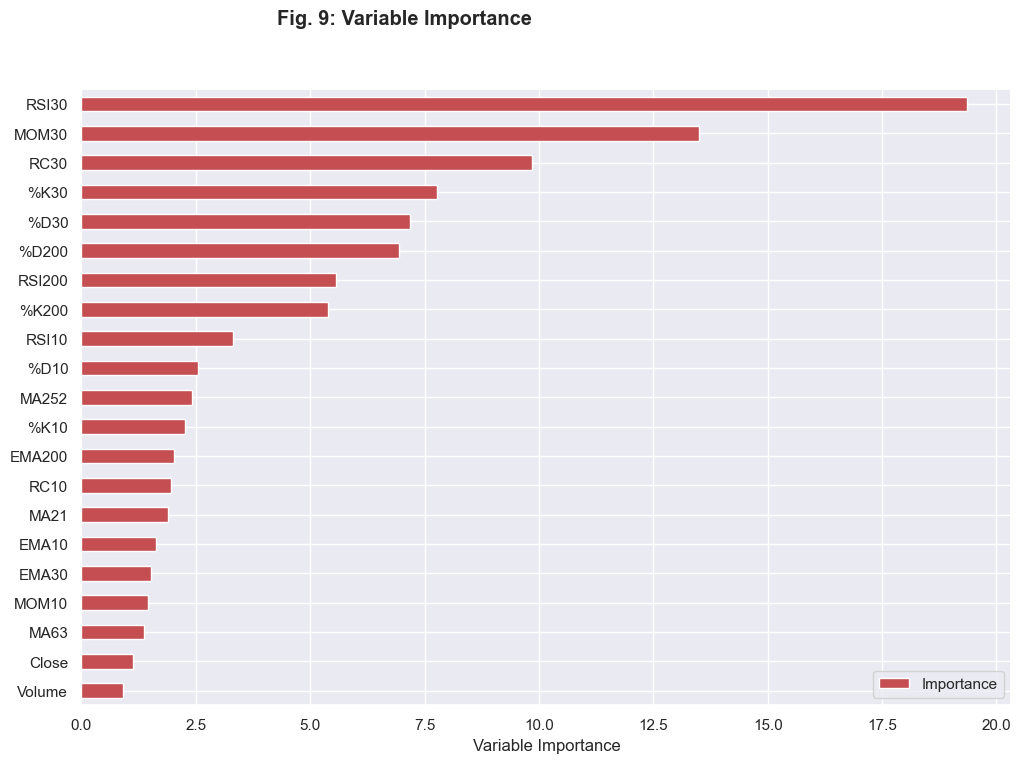

In [90]:
Importance = pd.DataFrame(
    {"Importance": model.feature_importances_ * 100}, index=X.columns
)
Importance.sort_values("Importance", axis=0, ascending=True).plot(
    kind="barh", color="r", figsize=(12, 8)
)
plt.xlabel("Variable Importance")
plt.suptitle(
    "Fig. 9: Variable Importance", fontweight="bold", horizontalalignment="right"
)
plt.show()

**Bayesian Optimization**

- The Bayesian optimization process uses the Gaussian process to model the mean and variance of the objective function. In every iteration, it tries different combinations of hyperparameter values and builds a new model using the model's past information. This has the advantage of reduding training time to achieve better results.
- We start by defining the stratified kFold function that will be used to perform cross-validation on the training dataset.

In [91]:
def stratified_kfold_score(clf, X_train, y_train, n_fold):
    X, y = X_train.values, y_train.values
    strat_kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in strat_kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        accuracy_test = accuracy_score(preds, y_test_fold)
        accuracy_list.append(accuracy_test)

    return np.array(accuracy_list).mean()

Also, a function with the model hyperparametrs we would like to tune, max_samples, max_features, and n_estimators:

In [92]:
def bo_params_rf(max_samples, n_estimators, max_features):
    params = {
        "max_samples": max_samples,
        "max_features": max_features,
        "n_estimators": int(n_estimators),
    }
    clf = RandomForestClassifier(
        max_samples=params["max_samples"],
        max_features=params["max_features"],
        n_estimators=params["n_estimators"],
    )
    score = stratified_kfold_score(clf, X_train, y_train, 5)
    return score

- Give a range of hyperparameter space that the Bayesian optimization will search:

In [93]:
rf_bo = BayesianOptimization(
    bo_params_rf,
    {"max_samples": (0.2, 1), "max_features": (0.5, 1), "n_estimators": (50, 200)},
)

- We now apply Bayesian optimization to search through the hyperparameter space and output the results at each iteration.

In [96]:
results = rf_bo.maximize(n_iter=200, init_points=20)

|   iter    |  target   | max_fe... | max_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.9231    | 0.5102    | 0.2512    | 112.2     |
| 2         | 0.9394    | 0.9237    | 0.8174    | 138.2     |
| 3         | 0.9365    | 0.922     | 0.812     | 153.1     |
| 4         | 0.9471    | 0.9248    | 0.8189    | 56.1      |
| 5         | 0.9375    | 0.5867    | 0.598     | 120.8     |
| 6         | 0.9413    | 0.6411    | 0.4863    | 147.6     |
| 7         | 0.9413    | 0.8661    | 0.9292    | 68.15     |
| 8         | 0.9394    | 0.9742    | 0.7703    | 191.1     |
| 9         | 0.9423    | 0.6179    | 0.8252    | 144.7     |
| 10        | 0.9346    | 0.7956    | 0.3888    | 120.4     |
| 11        | 0.9385    | 0.893     | 0.8274    | 112.1     |
| 12        | 0.9183    | 0.8059    | 0.2234    | 171.8     |
| 13        | 0.9442    | 0.8422    | 0.991     | 83.52     |
| 14        | 0.9337    | 0.859     | 0.5246    | 148.9     |
| 15    

- Display the best hyperparameters that have been accounted by Bayesian optimization.

In [97]:
params = rf_bo.max["params"]
params["n_estimators"] = int(params["n_estimators"])
print(params)

{'max_features': 0.6280113477473654, 'max_samples': 0.8221117766582153, 'n_estimators': 174}


- Fix hyperparameters in our model.

In [98]:
rf_v1 = RandomForestClassifier(
    max_samples=params["max_samples"],
    max_features=params["max_features"],
    n_estimators=params["n_estimators"],
)

- Use our training dataset to train the above model having the best selected hyperparameters:

In [99]:
rf_v1.fit(X_train, y_train)

RandomForestClassifier(max_features=0.6280113477473654,
                       max_samples=0.8221117766582153, n_estimators=174)

- Usingthe model to predict the holdout dataset.

In [100]:
preds = rf_v1.predict(X_test)

In [101]:
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95       124
         1.0       0.95      0.96      0.95       136

    accuracy                           0.95       260
   macro avg       0.95      0.95      0.95       260
weighted avg       0.95      0.95      0.95       260



- We can print out the values of precision score, recall, and f1 score to better shed light on the classification report.

In [102]:
print("Precision:{}".format(precision_score(preds, y_test)))
print("Recall:{}".format(recall_score(preds, y_test)))
print("F1 Score:{}".format((f1_score(preds, y_test))))

Precision:0.948905109489051
Recall:0.9558823529411765
F1 Score:0.9523809523809523


- Lets implement the stratfified kFold validatio:

In [103]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
scores = []

for (train, test), i in zip(cv.split(X_train, y_train), range(5)):
    rf_v1.fit(X.iloc[train], y.iloc[train])
    preds = rf_v1.predict(X_train.iloc[test])
    accuracy = accuracy_score(preds, y_train.iloc[test])
    scores.append(accuracy)

df_val = pd.DataFrame(scores, columns=["Accuracy Test"])
print(
    "KFold validation mean accuracy on test set : {}".format(
        df_val["Accuracy Test"].mean()
    )
)

KFold validation mean accuracy on test set : 0.9721153846153845


**Backtesting**

- To see how our trading strategy would perform on historical data, and this possibly with the help of backtesting. Backtesting alllows us to simulate how we would have performed in the past without using any financial capital. 

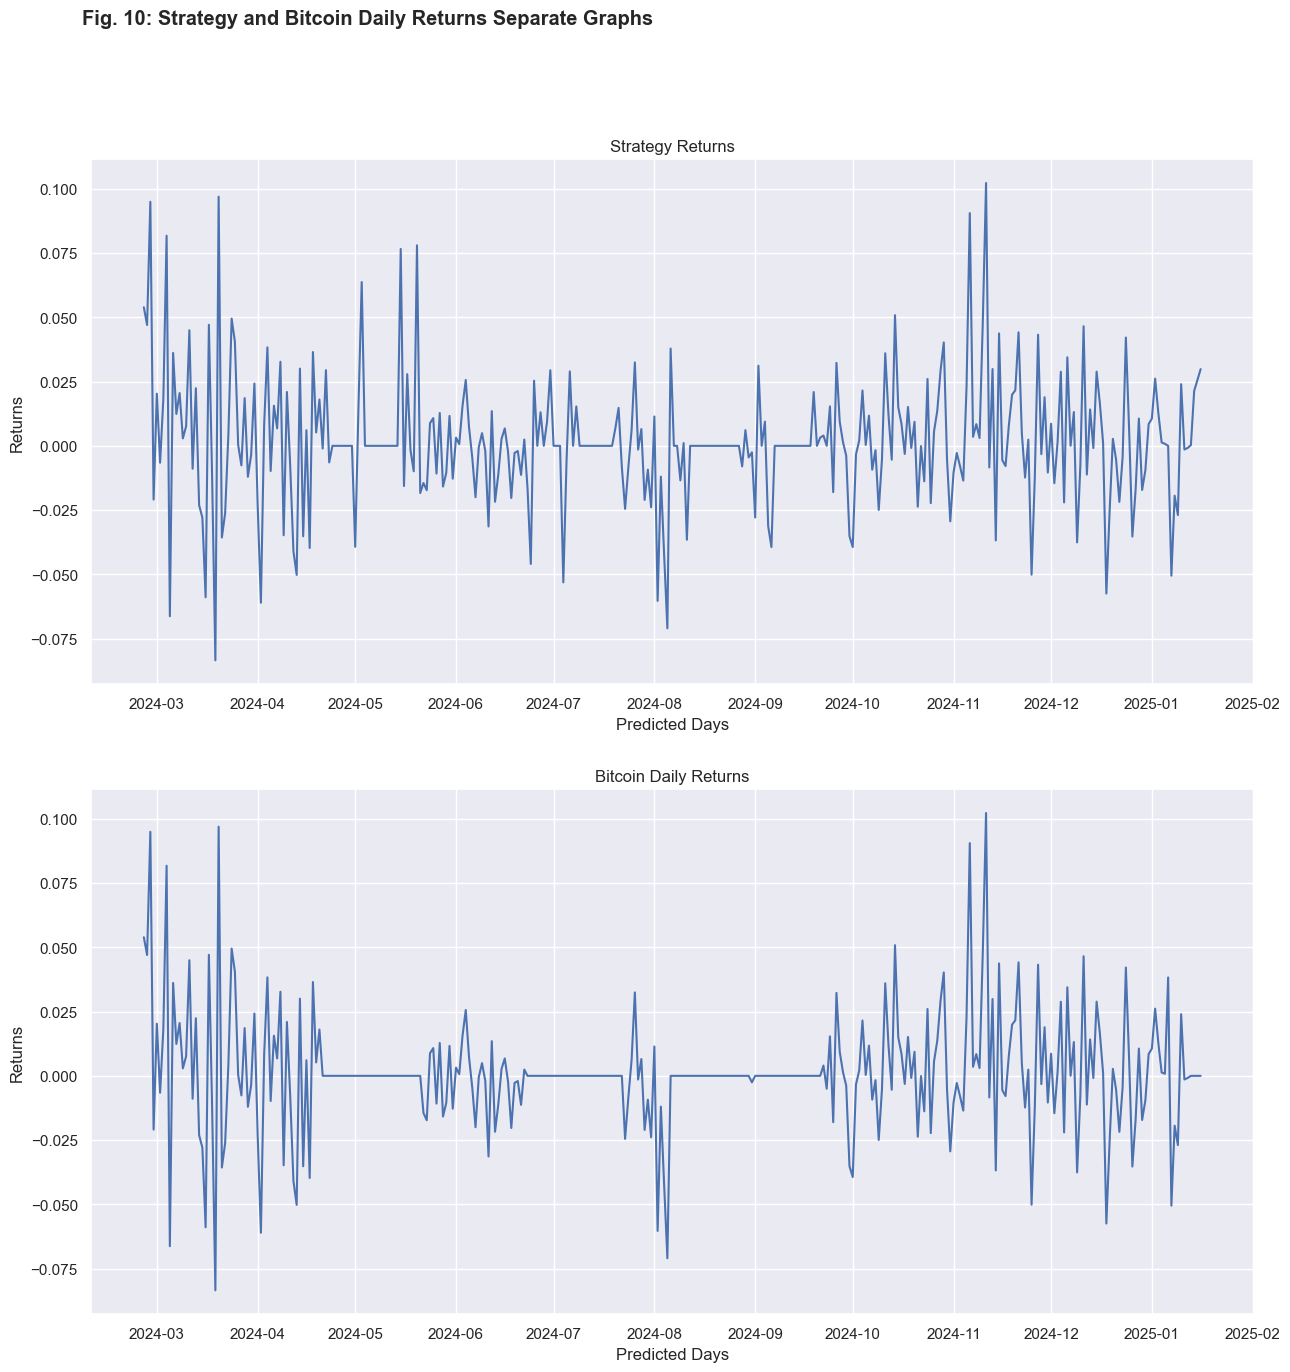

In [104]:
# Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
# of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)
validation_prediction = rf_v1.predict(X_validation)
backtestdata["signal_pred"] = validation_prediction
backtestdata["signal_actual"] = y_validation
backtestdata["Market Returns"] = X_validation["Close"].pct_change()
backtestdata["Actual Returns"] = backtestdata["Market Returns"] * backtestdata[
    "signal_actual"
].shift(1)
backtestdata["Strategy Returns"] = backtestdata["Market Returns"] * backtestdata[
    "signal_pred"
].shift(1)
# backtestdata=backtestdata.reset_index()
backtestdata.head()

fig, axs = plt.subplots(2, figsize=(15, 15))
fig.suptitle("Vertically stacked subplots")
axs[0].plot(backtestdata["Strategy Returns"])
axs[0].set_title("Strategy Returns")
axs[1].plot(backtestdata["Actual Returns"])
axs[1].set_title("Bitcoin Daily Returns")

for ax in axs.flat:
    ax.set(xlabel="Predicted Days", ylabel="Returns")

# `backtestdata`[['Strategy Returns','Actual Returns']].plot()
# `plt.title`('Cumulative Strategy Returns vs Cumulative Actual Returns')
plt.suptitle(
    "Fig. 10: Strategy and Bitcoin Daily Returns Separate Graphs",
    fontweight="bold",
    horizontalalignment="right",
)
plt.show()

- We visualize the strategy and Bitcoin daily returns in two seprate figures.

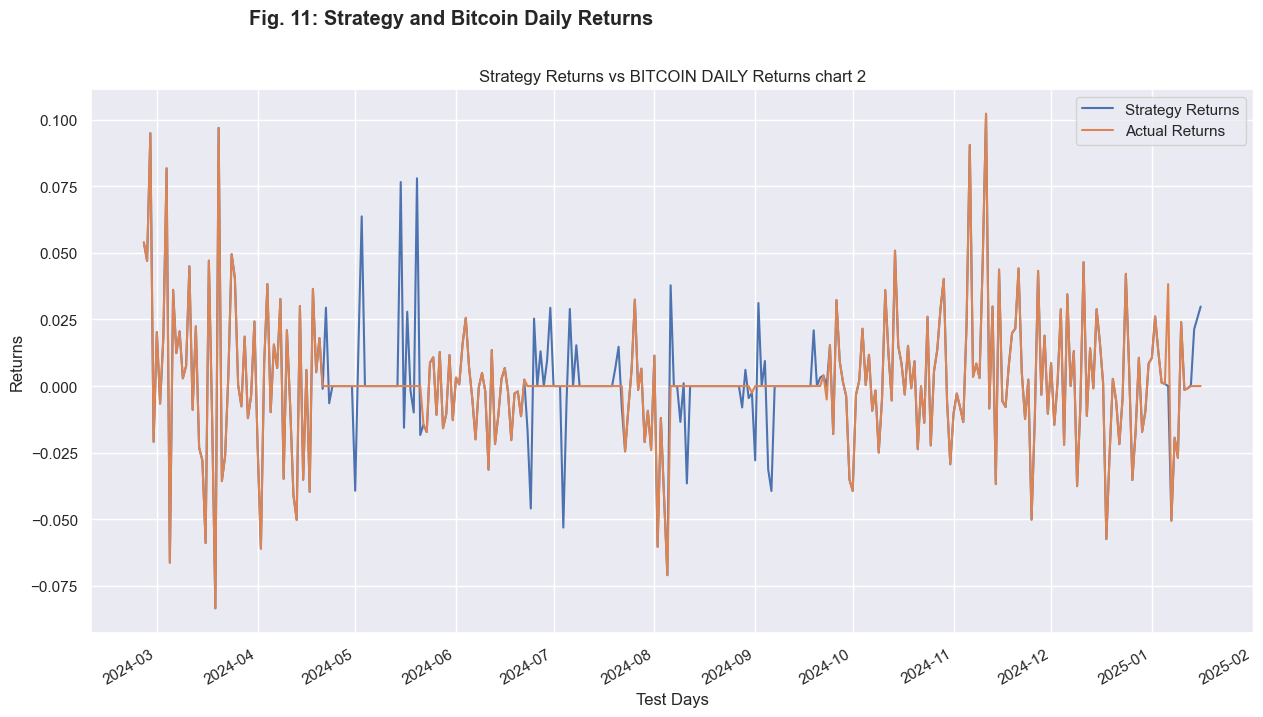

In [105]:
backtestdata[["Strategy Returns", "Actual Returns"]].plot(figsize=(15, 8))
plt.title("Strategy Returns vs BITCOIN DAILY Returns chart 2")
plt.suptitle(
    "Fig. 11: Strategy and Bitcoin Daily Returns",
    fontweight="bold",
    horizontalalignment="right",
)
plt.xlabel("Test Days")
plt.ylabel("Returns")
plt.show()

- We can clearly see that the strategy and Bitcoin daily return on most test days with exception of every few days. 
- We plot the cummulative returns for both strategy returns and Bitcoin returns to compare how we except to perform in the near future if we applied our trading model.

In [ ]:
backtestdata[["Strategy Returns", "Actual Returns"]].cumsum().plot(figsize=(15, 8))
plt.xlabel("Test Days")
plt.ylabel("Cumulative Returns")
plt.suptitle(
    "Fig. 12: Cumulative Strategy Returns vs Cumulative BITCOIN  Returns",
    fontweight="bold",
    horizontalalignment="right",
)
plt.show()